In [ ]:
import sqlite3

In [ ]:
import requests
import os
import csv
import sqlite3
import pandas as pd


# ---------下載資料---------#
def __download_credit_data() -> csv:
    area = [
        "KLC",
        "TPE",
        "NTP",
        "TYC",
        "HCC",
        "HCH",
        "MLH",
        "TCC",
        "CHH",
        "NTH",
        "YUH",
        "CYC",
        "CYH",
        "TNC",
        "KHC",
        "PTH",
        "TTH",
        "HLH",
        "YIH",
        "PHH",
        "KMH",
        "LCH",
        "X1",
        "LCSUM",
        "MCT",
        "LOC",
    ]
    area_code = {
        "63000000": "臺北市",
        "64000000": "高雄市",
        "65000000": "新北市",
        "66000000": "臺中市",
        "67000000": "臺南市",
        "68000000": "桃園市",
        "10002000": "宜蘭縣",
        "10004000": "新竹縣",
        "10005000": "苗栗縣",
        "10007000": "彰化縣",
        "10008000": "南投縣",
        "10009000": "雲林縣",
        "10010000": "嘉義縣",
        "10020000": "嘉義市",
        "10013000": "屏東縣",
        "10014000": "臺東縣",
        "10015000": "花蓮縣",
        "10016000": "澎湖縣",
        "10017000": "基隆市",
        "10018000": "新竹市",
        "9020000": "金門縣",
        "9007000": "連江縣",
    }
    industry = ["FD", "CT", "LG", "TR", "EE", "DP", "X2", "OT", " IDSUM", "ALL"]
    DataType = ["sex", "job", "incom", "education", "age"]
    sex = ["M", "F"]
    sex_code = {"1": "男性", "2": "女性"}

    # 兩性消費
    for A in industry:
        for B in area:
            sex_url = (
                f"https://bas.nccc.com.tw/nccc-nop/OpenAPI/C01/sexconsumption/{B}/{A}"
            )
            response_sex = requests.request("GET", sex_url)
            if len(response_sex.text) == 0:
                continue
            with open(f"./datasource/sex/sex{B}_{A}.csv", "wb") as file:
                file.write(response_sex.content)
                file.close()
    print("性別消費資料讀取成功")

    # 各職業類別消費樣態資料
    for E in industry:
        for F in area:
            job_url = (
                f"https://bas.nccc.com.tw/nccc-nop/OpenAPI/C04/jobsconsumption/{F}/{E}"
            )
            response_job = requests.request("GET", job_url)
            if len(response_job.text) == 0:
                continue
            with open(f"./datasource/job/job{F}_{E}.csv", "wb") as file:
                file.write(response_job.content)
                file.close()
    print("職業類別消費資料讀取成功")

    # 各年收入族群消費樣態資料(V)
    for G in industry:
        for H in area:
            incom_url = f"https://bas.nccc.com.tw/nccc-nop/OpenAPI/C03/incomegroupsconsumption/{H}/{G}"
            response_incom = requests.request("GET", incom_url)
            if len(response_incom.text) == 0:
                continue
            with open(f"./datasource/incom/incom{H}_{G}.csv", "wb") as file:
                file.write(response_incom.content)
                file.close()
    print("收入類別消費資料讀取成功")

    # 各教育程度消費樣態資料(V)
    for I in industry:
        for J in area:
            education_url = f"https://bas.nccc.com.tw/nccc-nop/OpenAPI/C05/educationconsumption/{J}/{I}"
            response_education = requests.request("GET", education_url)
            if len(response_education.text) == 0:
                continue
            with open(f"./datasource/education/education{J}_{I}.csv", "wb") as file:
                file.write(response_education.content)
                file.close()
    print("教育程度資料讀取成功")

    # 兩性X各年齡層消費
    for A in industry:
        for B in area:
            for C in sex:
                age_url = f"https://bas.nccc.com.tw/nccc-nop/OpenAPI/C11/GenderAgeGroup/{B}/{A}/{C}"
                response_age = requests.request("GET", age_url)
                if len(response_age.text) == 0:
                    continue
                folder_path = "./datasource/age/"
                file_name = f"age{B}_{A}_{C}.csv"
                file_path = os.path.join(folder_path, file_name)
                with open(file_path, "wb") as file:
                    file.write(response_age.content)
                    file.close()
    print("年齡層消費資料讀取成功")

    # ---------合併csv---------#
    for item in DataType:
        path = f"./datasource/{item}/"
        csv_files = [file for file in os.listdir(path) if file.endswith(".csv")]
        merged_data = pd.DataFrame()
        for file in csv_files:
            file_path = os.path.join(path, file)
            data = pd.read_csv(file_path)
            merged_data = pd.concat([merged_data, data], ignore_index=True)
        merged_data.to_csv(f"{item}.csv", index=False)
        print(f"{item}.csv建立成功")

        with open(f"./{item}.csv", "r", encoding="UTF-8") as csv_file:
            csv_reader = csv.DictReader(csv_file)
            fieldnames = csv_reader.fieldnames

            with open(f"./{item}_trans.csv", "w", encoding="utf-8", newline="") as file:
                new_fieldnames = ["年", "月"] + fieldnames[1:]
                csv_writer = csv.DictWriter(file, fieldnames=new_fieldnames)
                csv_writer.writeheader()

                for row in csv_reader:
                    # 使用get方法，如果找不到對應的鍵，就保持原來的值
                    row["地區"] = area_code.get(row["地區"], row["地區"])

                    if "性別" in fieldnames:
                        row["性別"] = sex_code.get(row["性別"], row["性別"])

                    year = row["年月"][:4]
                    month = row["年月"][4:]
                    new_row = {"年": year, "月": month, "地區": row["地區"]}

                    if "性別" in fieldnames:
                        new_row["性別"] = row["性別"]

                    new_row.update(row)
                    del new_row["年月"]
                    csv_writer.writerow(new_row)

                print(f"{item}_trans.csv建立成功")


# ---------輸入資料---------#
def csv_to_database(conn: sqlite3.Connection) -> None:
    DataType = ["sex", "job", "incom", "education", "age"]
    for item in DataType:
        file = f"./{item}_trans.csv"
        df = pd.read_csv(file)

        df.rename(columns={"信用卡交易金額[新台幣]": "信用卡金額"}, inplace=True)
        df.to_sql(item, conn, if_exists="append", index=False)

    conn.close()


def main() -> None:
    __download_credit_data()
    conn = sqlite3.connect("creditcard.db")
    csv_to_database(conn)


if __name__ == "__main__":
    main()

In [ ]:
# ---------合併csv---------#
import csv

with open(f"./age.csv", "r", encoding="UTF-8") as csv_file:
    csv_reader = csv.DictReader(csv_file)
    fieldnames = csv_reader.fieldnames

    with open(f"./age_trans.csv", "w", encoding="utf-8", newline="") as file:
        new_fieldnames = ["年", "月"] + fieldnames[1:]
        csv_writer = csv.DictWriter(file, fieldnames=new_fieldnames)
        csv_writer.writeheader()

        for row in csv_reader:
            year = row["年月"][:4]
            month = row["年月"][4:]
            new_row = {"年": year, "月": month}


            new_row.update(row)
            del new_row["年月"]
            csv_writer.writerow(new_row)

        print(f"age_test.csv建立成功")

In [54]:
from sklearn.preprocessing import LabelEncoder

# 初始化 LabelEncoder
label_encoder = LabelEncoder()

# 對產業別進行標籤編碼
df['產業別_encoded'] = label_encoder.fit_transform(df['產業別'])

# 對年齡層進行標籤編碼
df['年齡層_encoded'] = label_encoder.fit_transform(df['年齡層'])



# 顯示轉換後的 DataFrame
df


,年,月,地區,產業別,性別,年齡層,信用卡交易筆數,信用卡交易金額[新台幣],產業別_encoded,年齡層_encoded
0,2014,1,10007000,衣,2,未滿20歲,282,574794,5,13
1,2014,1,10007000,衣,2,20(含)-25歲,7091,16563668,5,0
2,2014,1,10007000,衣,2,25(含)-30歲,20467,52197577,5,1
3,2014,1,10007000,衣,2,30(含)-35歲,35400,93635594,5,2
4,2014,1,10007000,衣,2,35(含)-40歲,41102,113811652,5,3
...,...,...,...,...,...,...,...,...,...,...
478915,2019,5,66000000,其他,1,30(含)-35歲,44556,157027270,1,2
478916,2019,5,66000000,其他,1,35(含)-40歲,55700,197914842,1,3
478917,2019,5,66000000,其他,1,40(含)-45歲,50699,193734119,1,4
478918,2019,5,66000000,其他,1,45(含)-50歲,43283,191197430,1,5


In [ ]:
import pandas as pd

# 創建一個範例資料集
data = pd.read_csv("age_trans.csv")

# 進行獨熱編碼
data_encoded = pd.get_dummies(data, columns=['產業別', '年齡層'], prefix=['產業別', '年齡層'])

# 轉換布林型態欄位為整數型態
data_encoded = data_encoded.astype(int)

# 顯示編碼後的資料
print(data_encoded)


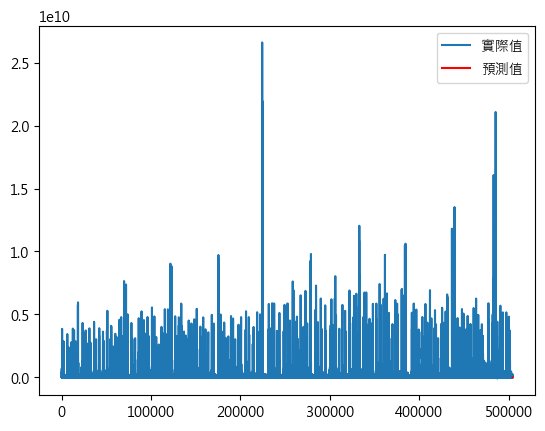

In [55]:
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt
plt.rcParams["font.family"] = "Microsoft JhengHei"

# 假設 df 是包含時間序列資料的資料框架
# 資料框架應該包含日期欄位和要預測的數值欄位
df = pd.read_csv("age.csv")

# 設定日期欄位為索引
df['年月'] = pd.to_datetime(df['年月'])
# 按照 '日期' 欄位進行排序
df = df.sort_values(by='年月')

# 重新設定索引
df = df.reset_index(drop=True)

# 將 '日期' 和 '信用卡交易金額' 欄位重命名，以符合 Prophet 的要求
df_prophet = df.rename(columns={'年月': 'ds', '信用卡交易金額[新台幣]': 'y'})


# 使用 ARIMA 模型進行預測
model = ARIMA(df['信用卡交易金額[新台幣]'], order=(1,1,1))  # 根據資料的情境調整 ARIMA 的參數
results = model.fit()

# 預測未來 n 個月
n = 3
forecast = results.get_forecast(steps=n)

# 繪製原始資料和預測值的趨勢圖
plt.plot(df['信用卡交易金額[新台幣]'], label='實際值')
plt.plot(forecast.predicted_mean, label='預測值', color='red')
plt.legend()
plt.show()


                         年             月           年齡層  信用卡交易金額[新台幣]   信用卡交易筆數
年             1.000000e+00 -5.535582e-02  9.401513e-16      0.057068  0.137027
月            -5.535582e-02  1.000000e+00  5.148411e-17      0.006046  0.010575
年齡層           9.401513e-16  5.148411e-17  1.000000e+00     -0.057045 -0.126150
信用卡交易金額[新台幣]  5.706770e-02  6.046361e-03 -5.704496e-02      1.000000  0.666974
信用卡交易筆數       1.370266e-01  1.057502e-02 -1.261501e-01      0.666974  1.000000


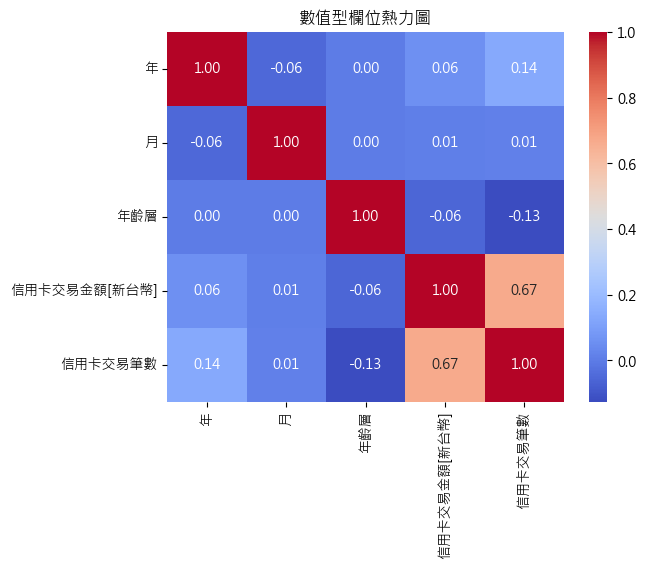

In [88]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

plt.rcParams["font.family"] = "Microsoft JhengHei"

# 假設 df 是包含 '信用卡交易金額[新台幣]' 和 '信用卡交易筆數' 欄位的資料框架
df = pd.read_csv("./modified_six_cities.csv")

# 選擇要繪製熱圖的數值型欄位
numeric_columns = ['年','月','年齡層','信用卡交易金額[新台幣]', '信用卡交易筆數']

# 提取這些欄位的子集
df_numeric = df[numeric_columns]

# 使用 seaborn 繪製熱圖
sns.heatmap(df_numeric.corr(), annot=True, cmap="coolwarm", fmt=".2f")

# 加上標題
plt.title('數值型欄位熱力圖')

# 顯示圖表
print(df_numeric.corr())
plt.show()


In [3]:
import pandas as pd

df = pd.read_csv("age_trans.csv")

cities = ['臺北市', '新北市', '桃園市', '臺中市', '臺南市', '高雄市']

# Initialize an empty DataFrame
data = pd.DataFrame()

for city in cities:
    cityData = df[(df['地區'] == city) & (df['產業別'] != '其他')]
    cityData.rename()
    data = pd.concat([data, cityData])

data.to_csv("six_cities.csv", index=False)


In [86]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# 假設 df 是包含 '信用卡交易金額' 和 '信用卡交易筆數' 欄位的資料框架
df = pd.read_csv("./modified_six_cities.csv")

df.describe()

,年,月,年齡層,信用卡交易筆數,信用卡交易金額[新台幣]
count,137592.000000,137592.000000,137592.000000,1.375920e+05,1.375920e+05
mean,2018.384615,6.384615,7.500000,7.466122e+04,1.491928e+08
std,2.815857,3.416529,4.031144,2.377602e+05,5.580423e+08
min,2014.000000,1.000000,1.000000,1.000000e+01,-9.275543e+07
25%,2016.000000,3.000000,4.000000,2.796000e+03,7.302901e+06
50%,2018.000000,6.000000,7.500000,1.460950e+04,4.031856e+07
75%,2021.000000,9.000000,11.000000,4.746525e+04,1.057340e+08
max,2023.000000,12.000000,14.000000,3.828945e+06,2.660613e+10


In [83]:
import sqlite3
def csv_to_database() -> None:
    conn = sqlite3.connect("test.db")
    
    df = pd.read_csv("./six_cities.csv")

    df.rename(columns={"信用卡交易金額[新台幣]": "信用卡金額"}, inplace=True)  #inplace=True->直接修改原始dataframe
    df.to_sql("six_city", conn, if_exists="replace", index=False)  #寫入資料庫中,if_exists="replace"->若table已經存在將其替換, index=False->不將dataframe的索引值寫入

    conn.close()

csv_to_database()

In [84]:
import csv

age_code = {"未滿20歲": "1", "20(含)-25歲": "2", "25(含)-30歲": "3", "30(含)-35歲": "4", "35(含)-40歲":"5", "40(含)-45歲":"6", "45(含)-50歲":"7", "50(含)-55歲":"8", "55(含)-60歲":"9", "60(含)-65歲":"10", "65(含)-70歲":"11", "70(含)-75歲":"12", "75(含)-80歲":"13", "80(含)歲以上":"14"}

with open("six_cities.csv", encoding="utf-8") as file:
    csv_reader = csv.DictReader(file)
    for row in csv_reader:
        #---找不到對應的值，則保持原本的值---#
        row["年齡層"] = age_code.get(row["年齡層"], row["年齡層"])


In [85]:
import csv

age_code = {"未滿20歲": "1", "20(含)-25歲": "2", "25(含)-30歲": "3", "30(含)-35歲": "4", "35(含)-40歲":"5", "40(含)-45歲":"6", "45(含)-50歲":"7", "50(含)-55歲":"8", "55(含)-60歲":"9", "60(含)-65歲":"10", "65(含)-70歲":"11", "70(含)-75歲":"12", "75(含)-80歲":"13", "80(含)歲以上":"14"}

# Open the input and output CSV files
with open("age.csv", encoding="utf-8") as input_file, open("modified_age.csv", mode="w", encoding="utf-8", newline='') as output_file:
    csv_reader = csv.DictReader(input_file)
    
    # Define the column names for the output CSV file
    fieldnames = csv_reader.fieldnames
    
    # Create a CSV writer for the output file
    csv_writer = csv.DictWriter(output_file, fieldnames=fieldnames)
    
    # Write the header to the output file
    csv_writer.writeheader()
    
    # Iterate through rows in the input file
    for row in csv_reader:
        # Update the "年齡層" column based on the age_code dictionary
        row["年齡層"] = age_code.get(row["年齡層"], row["年齡層"])
        
        # Write the modified row to the output file
        csv_writer.writerow(row)


In [1]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.tree import DecisionTreeClassifier
import pandas as pd

df = pd.read_csv('./modified_six_cities.csv')
x = df[['地區', '年齡層', '產業別']]
y = df['信用卡交易筆數']
x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.2)
dict = DictVectorizer(sparse=False)
x_train = x_train.to_dict(orient='records')
x_train = dict.fit_transform(x_train)
x_test = x_test.to_dict(orient='records')
x_test = dict.transform(x_test)
print('訓練資料：')
print(x_train)
print('onehot 特徵名稱：')
print(dict.get_feature_names_out())

FileNotFoundError: [Errno 2] No such file or directory: './modified_six_cities.csv'

In [9]:
dec = DecisionTreeClassifier()
dec.fit(x_train, y_train)
score = dec.score(x_test, y_test)
print(score)

0.0010901558922925979


In [48]:
from sklearn.tree import export_graphviz
from pydotplus import graph_from_dot_data, Dot
import graphviz

dot_data = export_graphviz(dec, out_file=None,
                feature_names=dict.get_feature_names_out(),
                class_names=[str(c) for c in dec.classes_],
                rounded=True, filled=True)

graph = graph_from_dot_data(dot_data)
graph.write_png('./dec.png')  

InvocationException: GraphViz's executables not found